# 3D Semantic Segmentation - Resume Training
---

# Setup
---

In [1]:
! pip install python-gdcm
! pip install pylibjpeg pylibjpeg-libjpeg pydicom
! pip install pyjpegls
! pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 7.6 MB/s eta 0:00:00


In [2]:
# Importing libraries
import os
import random
import string
import time
import csv
from tqdm import tqdm
from glob import glob
import csv
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.ndimage as ndi
import seaborn as sns
sns.set_theme(style="whitegrid")

# To read dicom file
import pydicom
from pydicom import dcmread

# To read nifti file
import nibabel as nib

# Required dependencies
import gdcm
import pylibjpeg

# Monai
from monai.data import ArrayDataset, DataLoader, decollate_batch
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.transforms import (
    Compose,
    Activations,
    AsDiscrete,
    Resize,
    Zoom,
    ScaleIntensity,
    RandFlip,
    RandGridDistortion,
    RandAffine
)
from monai.utils import set_determinism, first

# Sklearn
from sklearn.model_selection import KFold

# PyTorch
import torch
import torch.nn as nn
from torch.nn.functional import one_hot

/opt/conda/lib/python3.10/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


# Resume Configuration
---

In [3]:
# Path 
TRAIN_IMAGES_PATH = '/kaggle/input/rsna-2022-cervical-spine-fracture-detection/train_images'
SEGMENTATIONS_PATH = '/kaggle/input/rsna-2022-cervical-spine-fracture-detection/segmentations'
OUTPUT_DIR = '.'

MODEL_PATH = '/kaggle/input/resume-training-output/WL7266AD_last_model'
CONFIG_PATH = '/kaggle/input/resume-training-output/WL7266AD_config.pkl'

# Load config from the pkl file
with open(CONFIG_PATH, 'rb') as f:
    config = pickle.load(f)

for k, v in config.items(): print(f'{k}: {v}')

ID: WL7266AD
spatial_size: (128, 128, 128)
prob: 0.5
k: 5
batch_size: 4
epochs: 400
lr: 0.0001
loss_weights: (0.05, 0.95)
channels: (16, 32, 64, 128, 256)
strides: (2, 2, 2, 2)
kernel_size: 3
up_kernel_size: 3
num_res_units: 2
act: PRELU
dropout: 0.0
bias: True
val_fold_idx: 1


In [4]:
# New max number of epochs
config['epochs'] = 480

In [5]:
OUTPUT_FILE = OUTPUT_DIR + f'/{config["ID"]}_train_val_losses.csv'
                                      
CONFIG_FILE = OUTPUT_DIR + f'/{config["ID"]}_config.pkl'

In [6]:
# Save config to pickle file
with open(CONFIG_FILE, 'wb') as f:
    pickle.dump(config, f)

In [7]:
# Masks to be reverted 
revert_mask = [
    '1.2.826.0.1.3680043.1363',
    '1.2.826.0.1.3680043.20120',
    '1.2.826.0.1.3680043.2243',
    '1.2.826.0.1.3680043.24606',
    '1.2.826.0.1.3680043.32071'
    ]

# Set Deterministic Training for Reproducibility
---

In [8]:
set_determinism(seed=0)

# Setting Up PyTorch for GPU Acceleration
---

In [9]:
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Enable cuDNN benchmark. Set to True whenever the input model does not change over training, False if, eg, some layers are deactivated
torch.backends.cudnn.benchmark = True

GPU: Tesla T4 is available.
cuda


# Function Declaration
---

In [10]:
def read_dicom_scan(folder_path):
    """ Read CT scan (dicom files) and stack the slices"""
    slices = []
    for filename in sorted(os.listdir(folder_path), key=lambda x: int(x.split(".")[0])):
        if filename.endswith('.dcm'):
            filepath = os.path.join(folder_path, filename)
            ds = pydicom.dcmread(filepath)
            slices.append(ds.pixel_array)
    scan = np.stack(slices, -1).astype('float64')
    return scan


def read_nifti_file(file_path, revert_mask=revert_mask):
    """ Read nifit file segmentation"""    
    data = nib.load(file_path).get_fdata()
    shape = data.shape
    # Reorient because segmentations are done over the sagittal plane
    data = data.transpose(1, 0, 2)[::-1, :, ::-1]
    # Revert the files that have inverted sequence (from bottom to top)
    if file_path in revert_mask:
        data[:, :, ::-1]
    return data


def zoom_volume(vol, spatial_size):
    """Resize across z-axis"""
    """ NON UTILIZZATA SOSTITUITA DA RESIZE"""
    # Set the desired depth
    desired_width, desired_height, desired_depth = spatial_size
    # Get current depth
    current_depth = vol.shape[-1]
    current_width = vol.shape[0]
    current_height = vol.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Resize across z-axis
    #vol = ndi.zoom(vol, (width_factor, height_factor, depth_factor), order=0, mode='constant')
    zoom_transform = Zoom(zoom=(width_factor, height_factor, depth_factor), keep_size=False)
    zoom_vol = zoom_transform(vol)
    return zoom_vol

def one_hot_encoding_multiclass_mask(mask):
    """ Binary OneHot Encoding of Multi-class masks"""
    labels = list(range(8))
    num_labels = len(labels)
    c, h, w, d = mask.shape
    enc_mask = np.zeros((num_labels, h, w, d))
    for c in range(1, num_labels):  # this loop starts from label 1 to ignore background 0
        enc_mask[c, :, :, :] = (mask == labels[c]) # 1 for the pixel belonging to that class, 0 for the rest of the pixel
        
    return enc_mask

def expand_dims(arr):
    return np.expand_dims(arr, axis=0)

def training_plot(file, output_path, config):
    """Plot Training and Validation losses, namely dice, bce (binary cross entorpy) and dice_bce"""
    # Training losses
    train_bce_dice_loss = file['train_bce_dice_loss']
    train_dice_loss = file['train_dice_loss']
    train_bce_loss = file['train_bce_loss']
    # Validation losses
    val_bce_dice_loss = file['val_bce_dice_loss']
    val_dice_loss = file['val_dice_loss']
    val_bce_loss = file['val_bce_loss']
    
    epochs = range(1, len(train_bce_dice_loss) + 1)
    
    # Plot Train Losses
    plt.plot(epochs, train_bce_dice_loss, label='train_bce_dice_loss', color='darkorange')
    plt.plot(epochs, train_dice_loss, label='train_dice_loss', color='antiquewhite', linestyle='dashed')
    plt.plot(epochs, train_bce_loss, label='train_bce_loss', color='tan', linestyle='dotted')
    
    # Plot Val Losses
    plt.plot(epochs, val_bce_dice_loss, label='val_bce_dice_loss', color='darkblue')
    plt.plot(epochs, val_dice_loss, label='val_dice_loss', color='lavender', linestyle='dashed')
    plt.plot(epochs, val_bce_loss, label='val_bce_loss', color='slateblue', linestyle='dotted')
    
    plt.title('Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.legend()
    plt.grid(False)
    plt.savefig(os.path.join(output_path, f'{config["ID"]}_Training_plot.png'))
    plt.show()

def validation_metric_plot(file, output_path, config):
    val_dice_metric = file['val_dice_metric']
    epochs = range(1, len(val_dice_metric)+1)
    plt.plot(epochs, val_dice_metric, label='Validation Dice Metric', color='red')
    plt.title('Validation Metric')
    plt.xlabel('Epochs')
    plt.legend()
    plt.grid(False)
    plt.savefig(os.path.join(output_path, f'{config["ID"]}_Validation_Metric_plot.png'))
    plt.show()

# Dataset
---

In [11]:
# Create Dataset
df = pd.DataFrame()

# Store all the nifti files in the segmentation folder
df['ID'] = os.listdir(SEGMENTATIONS_PATH)

# Remove the extension '.nii'
df['ID'] = df['ID'].apply(lambda x: x[:-4])

# Add complete path to reach segmentation file (nifti)
df['label_path'] = df['ID'].apply(lambda x: os.path.join(SEGMENTATIONS_PATH, x + '.nii'))

# Add complete path to reach CT scan folder in train_images
df['image_path'] = df['ID'].apply(lambda x: os.path.join(TRAIN_IMAGES_PATH, x))

# Initialize KFold
kf = KFold(n_splits=config['k'], shuffle=True, random_state=42)

# Create a new column for fold indices
df['fold'] = -1

# Assign fold indices
for fold, (train_index, val_index) in enumerate(kf.split(df)):
    df.loc[val_index, 'fold'] = fold

# Print the shape of the dataset
print(df.shape)

# Show the head
df.head()

(87, 4)


,ID,label_path,image_path,fold
0,1.2.826.0.1.3680043.780,/kaggle/input/rsna-2022-cervical-spine-fractur...,/kaggle/input/rsna-2022-cervical-spine-fractur...,0
1,1.2.826.0.1.3680043.21321,/kaggle/input/rsna-2022-cervical-spine-fractur...,/kaggle/input/rsna-2022-cervical-spine-fractur...,4
2,1.2.826.0.1.3680043.6125,/kaggle/input/rsna-2022-cervical-spine-fractur...,/kaggle/input/rsna-2022-cervical-spine-fractur...,4
3,1.2.826.0.1.3680043.30067,/kaggle/input/rsna-2022-cervical-spine-fractur...,/kaggle/input/rsna-2022-cervical-spine-fractur...,2
4,1.2.826.0.1.3680043.12833,/kaggle/input/rsna-2022-cervical-spine-fractur...,/kaggle/input/rsna-2022-cervical-spine-fractur...,0


In [12]:
# Define training and validation dataset

val_fold_idx = config['val_fold_idx']

df_train = df[df.fold != val_fold_idx].reset_index()
print(df_train.shape)

df_val = df[df.fold == val_fold_idx].reset_index()
print(df_val.shape)

(69, 5)
(18, 5)


# Transforms
---

## Train Transforms

In [13]:
# Define transforms for image
train_image_trans = Compose(
    [   # Load Data
        read_dicom_scan,
        # Data Preparation
        expand_dims, 
        Resize(spatial_size=config['spatial_size'], mode="area"), # Resize the volume to target spatial_size
        ScaleIntensity(), # Scale between (0,1)
        # Data Augmentation 
        RandFlip(prob=config['prob'], spatial_axis=0), # Width
        RandFlip(prob=config['prob'], spatial_axis=1), # Height
        RandGridDistortion(num_cells=5, distort_limit=(-0.03, 0.03), prob=config['prob']),
        RandAffine(prob=config['prob'], 
                   translate_range=[int(x*y) for x, y in zip(config['spatial_size'], [0.3, 0.3, 0.3])], padding_mode='zeros')
    ]
)

# Define transforms for label
train_label_trans = Compose(
    [   # Load data
        read_nifti_file,
        # Data Preparation
        expand_dims,
        Resize(spatial_size=config['spatial_size'], mode="area"),
        one_hot_encoding_multiclass_mask, 
        # Data Augmentation
        RandFlip(prob=config['prob'], spatial_axis=0), # Width
        RandFlip(prob=config['prob'], spatial_axis=1), # Height
        RandGridDistortion(num_cells=5, distort_limit=(-0.03, 0.03), prob=config['prob']),
        RandAffine(prob=config['prob'], 
                   translate_range=[int(x*y) for x, y in zip(config['spatial_size'], [0.3, 0.3, 0.3])], padding_mode='zeros')
    ]
)

# Define train dataset, dataloader
train_ds = ArrayDataset(df_train.image_path, train_image_trans, df_train.label_path, train_label_trans)

train_loader = DataLoader(train_ds, 
                          batch_size=config['batch_size'], 
                          shuffle=True,
                          num_workers=2)

## Validation Transforms

In [14]:
# Define transforms for image
val_image_trans = Compose(
    [   # Load Data
        read_dicom_scan,
        # Data Preparation
        expand_dims, 
        Resize(spatial_size=config['spatial_size'], mode="area"), # Resize the volume to target spatial_size
        ScaleIntensity() # Scale between (0,1)
    ]
)

# Define transforms for label
val_label_trans = Compose(
    [   # Load data
        read_nifti_file,
        # Data Preparation
        expand_dims,
        Resize(spatial_size=config['spatial_size'], mode="area"),
        one_hot_encoding_multiclass_mask
    ]
)

# Define train dataset, dataloader
val_ds = ArrayDataset(df_val.image_path, val_image_trans, df_val.label_path, val_label_trans)

val_loader = DataLoader(val_ds, 
                        batch_size=config['batch_size'], 
                        shuffle=False,
                        num_workers=2
                       )

# Instantiate Model, Optimizer and Scheduler
---

In [15]:
# Create Model with UNet architecture
model = UNet(spatial_dims=3, # (Height, Width, Depth)
             in_channels=1,  
             out_channels=8, # 8 binary mask 7 as the vertebrae(C1->C7) + background
             channels=config['channels'], 
             strides=config['strides'], 
             kernel_size=config['kernel_size'], 
             up_kernel_size=config['up_kernel_size'], 
             num_res_units=config['num_res_units'], 
             act=config['act'], 
             dropout=config['dropout'], 
             bias=config['bias']
            ).to(device)

# Define the transforms to apply to model prediction, Softmax because multiclass segmentation problem
post_trans = Compose([Activations(sigmoid=False, softmax=True, dim=0), AsDiscrete(threshold=0.5)])

# AdamW optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr = config['lr'] )

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['epochs'])

# Use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()

/tmp/ipykernel_24/3489489263.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


# Resume training from checkpoint
---

In [16]:
# Resume state from checkpoint
checkpoint = torch.load(MODEL_PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])
start_epoch = checkpoint['epoch']+1
loss = checkpoint['loss']

/tmp/ipykernel_24/945172103.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_PATH)


# Losses & Metric
---

In [17]:
# Define Dice Loss
dice_loss_function = DiceLoss(include_background=True,  # If False, channel index 0 (background) is excluded from the calculation
                              softmax=True,              # Softmax to raw prediction because multi-class segmentation problem
                              sigmoid=False, 
                              squared_pred=True,        # Use squared versions of targets and predictions in the denominator or not
                              reduction='mean'           # Reduction to apply to the output
                              )

# Define Binary CrossEntropy With Logits Loss, PyTorch implementation
bce_loss_function = nn.BCEWithLogitsLoss()

# Combine BCE and Dice losses
def bce_dice_loss_function(input, target, loss_weights=config['loss_weights']):
    bce_loss = loss_weights[0] * bce_loss_function(input, target)
    dice_loss = loss_weights[1] * dice_loss_function(input, target)
    total_loss = (bce_loss + dice_loss) / sum(loss_weights)
    return total_loss

# Define Dice Metric
metric = DiceMetric(include_background=True, reduction="mean")

# Training Loop
---

In [18]:
# Container to store train losses values per epoch
train_bce_dice_loss_values = []
train_dice_loss_values = []
train_bce_loss_values = []

# Container to store val loss values per epoch
val_bce_dice_loss_values = []
val_dice_loss_values = []
val_bce_loss_values = []

# Container to store val metric values per epoch
val_dice_metric_values = []

# Store best val metric
best_val_metric = -1

total_start = time.time()
# Iterate over the epochs
for epoch in range(start_epoch, config['epochs']+1):
    epoch_start = time.time()
    print("-" * 10)
    print(f"EPOCH {epoch}/{config['epochs']}")
    model.train() # Set the model in training mode
    batch_bce_dice_losses = 0
    batch_bce_losses = 0
    batch_dice_losses = 0
    batch_val_bce_dice_losses = 0
    batch_val_dice_losses = 0
    batch_val_bce_losses = 0
    # Iterate over the batches
    for step, batch_data in enumerate(train_loader):
        step_start = time.time()
        inputs, labels = batch_data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad() # Clear the old gradients before computing new ones
        # Enable automatic mixed precision (amp)
        with torch.cuda.amp.autocast():
            outputs = model(inputs) # Make predictions for current batch
            # Compute train losses
            bce_dice_loss = bce_dice_loss_function(outputs, labels)
            dice_loss = dice_loss_function(outputs, labels)
            bce_loss = bce_loss_function(outputs, labels)
        scaler.scale(bce_dice_loss).backward() # Compute the gradients
        scaler.step(optimizer) # Update model weights
        scaler.update()
        
        batch_bce_dice_losses += bce_dice_loss.item()
        batch_bce_losses += bce_loss.item()
        batch_dice_losses += dice_loss.item()
        
        # REPORT PER BATCH 
        print(
            f"batch: {step}/{len(train_ds) // train_loader.batch_size}"
            f", bce_dice: {bce_dice_loss.item():.4f}"
            f", dice_loss: {dice_loss.item():.4f}"
            f", bce_loss: {bce_loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    lr_scheduler.step()
        
    # Compute average train loss per epoch
    avg_bce_dice_loss = batch_bce_dice_losses / (step + 1)
    avg_dice_loss = batch_dice_losses / (step + 1)
    avg_bce_loss = batch_bce_losses / (step + 1)
    
    # EVALUATE MODEL ON VALIDATION SET
    model.eval() # Set the model to evaluation mode
    with torch.no_grad(): # Disable gradient computation and reduce memory consumption.
        for step, val_data in enumerate(val_loader):
            val_inputs, val_labels = val_data
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            # Compute val losses
            val_bce_dice_loss = bce_dice_loss_function(val_outputs, val_labels)
            batch_val_bce_dice_losses += val_bce_dice_loss.item()
            val_dice_loss = dice_loss_function(val_outputs, val_labels)
            batch_val_dice_losses += val_dice_loss.item()
            val_bce_loss = bce_loss_function(val_outputs, val_labels)
            batch_val_bce_losses += val_bce_loss.item()
            # Compute val metric
            val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
            metric(y_pred=val_outputs, y=val_labels)
        
        # Compute average val loss per epoch
        avg_val_bce_dice_loss = batch_val_bce_dice_losses / (step + 1)
        avg_val_dice_loss = batch_val_dice_losses / (step + 1)
        avg_val_bce_loss = batch_val_bce_losses / (step + 1)
        avg_val_dice_metric = metric.aggregate().item()
    
    # REPORT PER EPOCH
    print(f'TRAIN LOSSES, bce_dice: {avg_bce_dice_loss:.4f}, bce:{avg_bce_loss:.4f}, dice:{avg_dice_loss:.4f}')
    print(f'VALID LOSSES, bce_dice: {avg_val_bce_dice_loss:.4f}, bce:{avg_val_bce_loss:.4f}, dice:{avg_val_dice_loss:.4f}')
    print(f'VALID METRIC, dice: {avg_val_dice_metric:.4f}')
    
    # Store train and val losses & metrics per epoch    
    train_bce_dice_loss_values.append(avg_bce_dice_loss) 
    train_dice_loss_values.append(avg_dice_loss)
    train_bce_loss_values.append(avg_bce_loss)
    val_bce_dice_loss_values.append(avg_val_bce_dice_loss)
    val_dice_loss_values.append(avg_val_dice_loss)
    val_bce_loss_values.append(avg_val_bce_loss)
    val_dice_metric_values.append(avg_val_dice_metric)
    
    metric.reset()
    
    # Track best performance, and save the best model's state
    if avg_val_dice_metric > best_val_metric:
        best_val_metric = avg_val_dice_metric
        best_model = {'epoch': epoch,
                      'model_state_dict': model.state_dict(),
                      'optimizer_state_dict': optimizer.state_dict(),
                      'lr_scheduler_state_dict': lr_scheduler.state_dict(),
                      'loss': avg_bce_dice_loss
                     }
            
    print(f"time consuming of epoch {epoch} is: {(time.time() - epoch_start):.4f}")
    
    # Save last model's state
    if epoch == config['epochs']:
        last_model = {'epoch': epoch,
                      'model_state_dict': model.state_dict(),
                      'optimizer_state_dict': optimizer.state_dict(),
                      'lr_scheduler_state_dict': lr_scheduler.state_dict(),
                      'loss': avg_bce_dice_loss
                      }

total_time = time.time() - total_start
    
# Save Train and Val Loss 
with open(OUTPUT_FILE, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['train_bce_dice_loss', 'train_dice_loss', 'train_bce_loss', 
                       'val_bce_dice_loss', 'val_dice_loss', 'val_bce_loss', 
                       'val_dice_metric'])
    csvwriter.writerows(zip(train_bce_dice_loss_values, train_dice_loss_values, train_bce_loss_values,
                           val_bce_dice_loss_values, val_dice_loss_values, val_bce_loss_values, 
                           val_dice_metric_values))

# Save Best Model's State
best_model_path = os.path.join(OUTPUT_DIR, f"{config['ID']}_best_model")
torch.save(best_model, best_model_path)

# Save Last Model's State
last_model_path = os.path.join(OUTPUT_DIR, f"{config['ID']}_last_model")
torch.save(last_model, last_model_path)

----------
EPOCH 401/480


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/tmp/ipykernel_24/3748024381.py:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


batch: 0/17, bce_dice: 0.2475, dice_loss: 0.2463, bce_loss: 0.2705, step time: 6.0451
batch: 1/17, bce_dice: 0.2509, dice_loss: 0.2500, bce_loss: 0.2684, step time: 0.3302
batch: 2/17, bce_dice: 0.3258, dice_loss: 0.3288, bce_loss: 0.2691, step time: 0.3967
batch: 3/17, bce_dice: 0.2515, dice_loss: 0.2509, bce_loss: 0.2639, step time: 0.3220
batch: 4/17, bce_dice: 0.2393, dice_loss: 0.2379, bce_loss: 0.2668, step time: 0.4128
batch: 5/17, bce_dice: 0.2272, dice_loss: 0.2249, bce_loss: 0.2714, step time: 0.3306
batch: 6/17, bce_dice: 0.4535, dice_loss: 0.4633, bce_loss: 0.2676, step time: 0.4009
batch: 7/17, bce_dice: 0.2589, dice_loss: 0.2583, bce_loss: 0.2703, step time: 0.3276
batch: 8/17, bce_dice: 0.2532, dice_loss: 0.2525, bce_loss: 0.2658, step time: 0.3857
batch: 9/17, bce_dice: 0.3481, dice_loss: 0.3525, bce_loss: 0.2645, step time: 0.3293
batch: 10/17, bce_dice: 0.2223, dice_loss: 0.2197, bce_loss: 0.2710, step time: 0.4121
batch: 11/17, bce_dice: 0.2594, dice_loss: 0.2590, bc

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


batch: 17/17, bce_dice: 0.2432, dice_loss: 0.2420, bce_loss: 0.2665, step time: 1.3769
TRAIN LOSSES, bce_dice: 0.2775, bce:0.2677, dice:0.2780
VALID LOSSES, bce_dice: 0.3998, bce:0.2686, dice:0.4067
VALID METRIC, dice: 0.6419
time consuming of epoch 401 is: 495.5329
----------
EPOCH 402/480
batch: 0/17, bce_dice: 0.2486, dice_loss: 0.2476, bce_loss: 0.2686, step time: 0.4062
batch: 1/17, bce_dice: 0.3569, dice_loss: 0.3616, bce_loss: 0.2676, step time: 0.3366
batch: 2/17, bce_dice: 0.2870, dice_loss: 0.2882, bce_loss: 0.2640, step time: 0.4203
batch: 3/17, bce_dice: 0.2461, dice_loss: 0.2450, bce_loss: 0.2668, step time: 0.3324
batch: 4/17, bce_dice: 0.2391, dice_loss: 0.2376, bce_loss: 0.2684, step time: 0.4251
batch: 5/17, bce_dice: 0.3111, dice_loss: 0.3133, bce_loss: 0.2682, step time: 0.3375
batch: 6/17, bce_dice: 0.2233, dice_loss: 0.2210, bce_loss: 0.2663, step time: 0.4000
batch: 7/17, bce_dice: 0.2626, dice_loss: 0.2622, bce_loss: 0.2692, step time: 0.3275
batch: 8/17, bce_dic

# Plot Training & Validation Losses
---

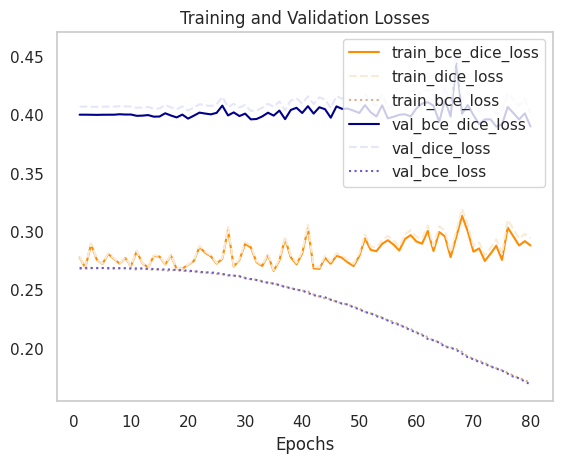

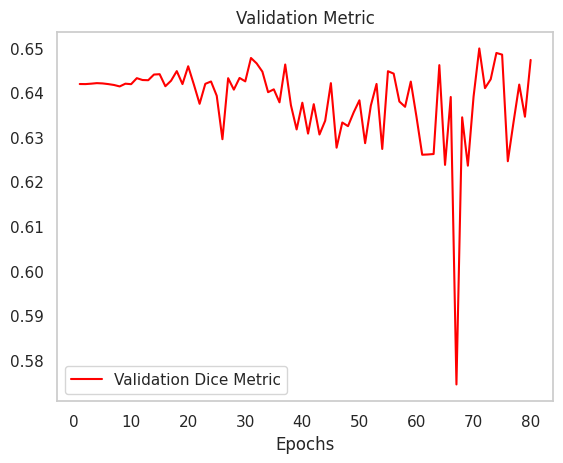

In [19]:
# Load txt file
path = f"/kaggle/working/{config['ID']}_train_val_losses.csv"
train_val_losses = pd.read_csv(path)

# Plot and Save Train Val Losses as png in output dir
training_plot(train_val_losses, OUTPUT_DIR, config)
validation_metric_plot(train_val_losses, OUTPUT_DIR, config)